Neste estudo de caso vamos usar o dataset *bank marketing* disponível no [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Bank+Marketing). O dataset trata de uma campanha de marketing de um banco português que tinha como objetivo fazer os clientes investirem em um tipo de investimento de renda fixa (*term deposit*).

O objetivo aqui é usar modelos de classificação para prever quais clientes farão o investimento.

## Carregando os pacotes necessários

In [188]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score

## Exploração dos Dados

In [189]:
bank = pd.read_csv("../data/bank-additional-full.csv", sep=";")

In [3]:
bank.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [4]:
bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

Temos então 21 variáveis. sendo `y` a variável dependente. Além disso cabe notar que não temos nenhuma variável com valores nulos, então não será necessário utilizar algum método de imputação.

Podemos perceber também que é uma base desbalanceada: cerca de 11% da categoria positiva na variável dependente. Um classificador que prevê somente "no" nos daria cerca de 88% de acurácia, apesar de ser inútil.

### Análise Univariada

In [5]:
sns.set_theme(style="darkgrid", context="notebook")

In [6]:
bank["y"].value_counts() / len(bank)

no     0.887346
yes    0.112654
Name: y, dtype: float64

#### Variáveis Numéricas

In [7]:
bank.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


Pelas estatísticas descritivas, é possível perceber que algumas das variáveis podem ter outliers, tais como `age`, `duration`, `campaign`, `pdays` e `previous`. Nessas variáveis, os valores tendem a estar concentrados com valores de máximos e mínimos discrepantes em relação à média ou percentis das variáveis. Será necessário investigar um pouco essas variáveis.

Vamos plotar essas variáveis para visualizarmos melhor seus padrões.

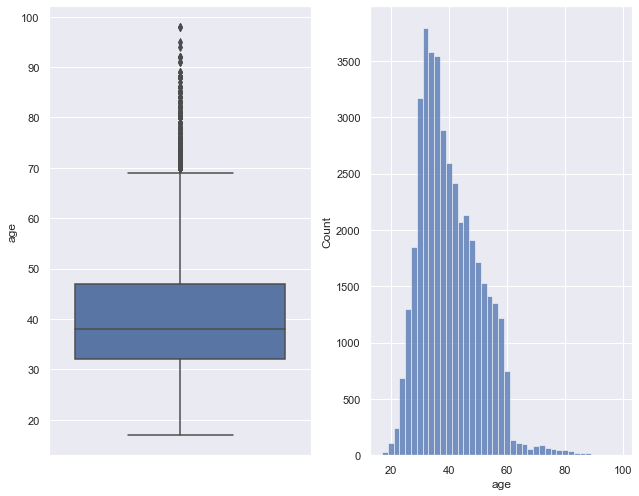

In [8]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(9, 7))

sns.boxplot(y="age", data=bank, ax=ax1)
sns.histplot(x="age", binwidth=2, data=bank, ax=ax2)
plt.tight_layout()
plt.show()

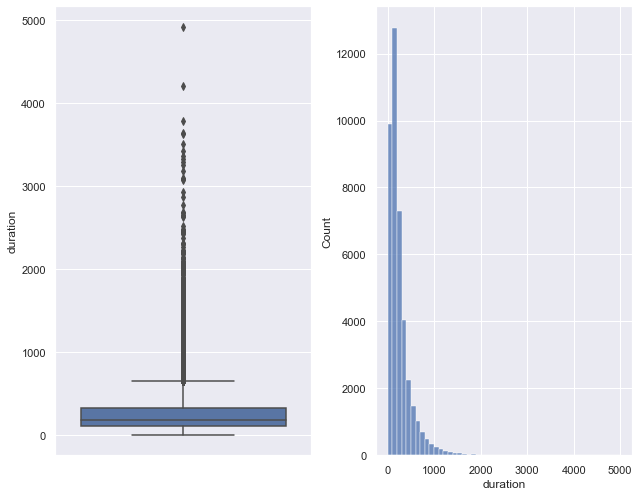

In [9]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(9, 7))

sns.boxplot(y="duration", data=bank, ax=ax1)
sns.histplot(x="duration", binwidth=100,data=bank, ax=ax2)
plt.tight_layout()
plt.show()

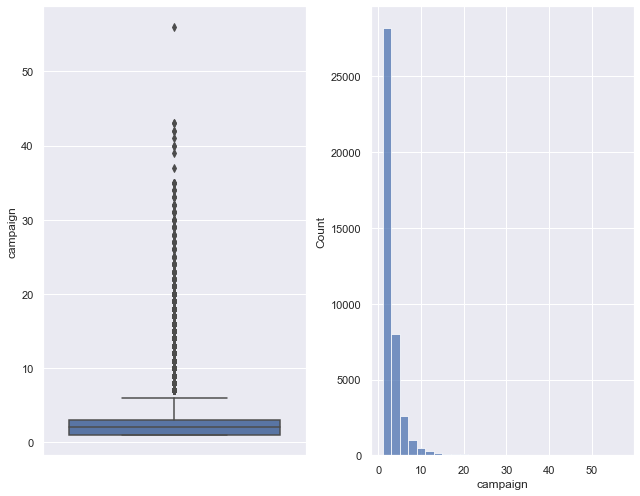

In [10]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(9, 7))

sns.boxplot(y="campaign", data=bank, ax=ax1)
sns.histplot(x="campaign", binwidth=2,data=bank, ax=ax2)
plt.tight_layout()
plt.show()

muitos outliers. pensar no que fazer

In [11]:
bank["pdays"].value_counts().sort_index()

0         15
1         26
2         61
3        439
4        118
5         46
6        412
7         60
8         18
9         64
10        52
11        28
12        58
13        36
14        20
15        24
16        11
17         8
18         7
19         3
20         1
21         2
22         3
25         1
26         1
27         1
999    39673
Name: pdays, dtype: int64

In [12]:
bank["previous"].value_counts().sort_index()

0    35563
1     4561
2      754
3      216
4       70
5       18
6        5
7        1
Name: previous, dtype: int64

Alguns destaques:

* Criar categorias para `age`, `campaign`, `pdays` e `previous`: todas as quatro variáveis sofrem com alguns outliers e tendem a estar concentradas em alguns valores;
* A variável `duration` também é concentrada em alguns valores. Mas ela será descartada pois é pouco útil na criação de um modelo realista: só se sabe a duração da ligação uma vez feita a ligação e do cliente decidir ou não pelo investimento. Portanto é uma variável que não dá pra prever *ex-ante*.

#### Variáveis Categoricas

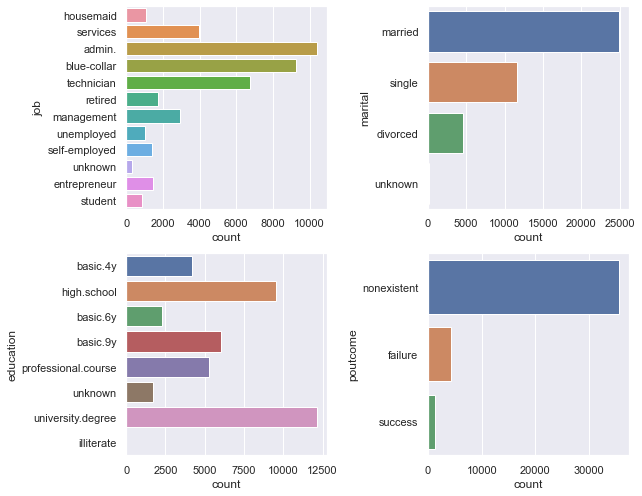

In [13]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(9, 7))

sns.countplot(y="job", data=bank, ax=axs[0, 0])
sns.countplot(y="marital", data=bank, ax=axs[0, 1])
sns.countplot(y="education", data=bank, ax=axs[1, 0])
sns.countplot(y="poutcome", data=bank, ax=axs[1, 1])
plt.tight_layout()
plt.show()

In [14]:
bank["marital"].value_counts()

married     24928
single      11568
divorced     4612
unknown        80
Name: marital, dtype: int64

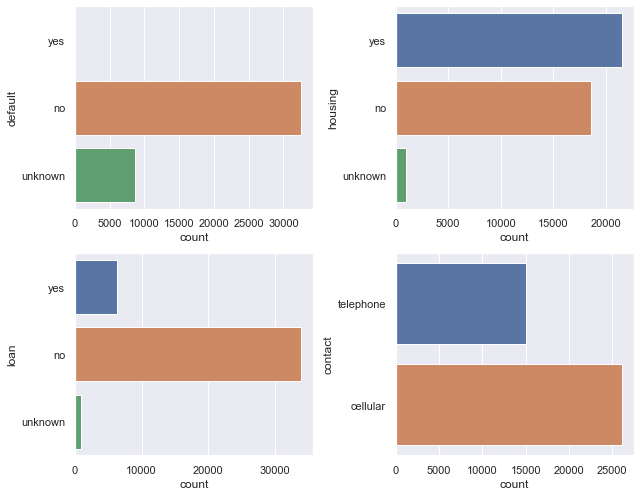

In [15]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(9, 7))

sns.countplot(y="default", data=bank, ax=axs[0, 0], order=["yes", "no", "unknown"])
sns.countplot(y="housing", data=bank, ax=axs[0, 1], order=["yes", "no", "unknown"])
sns.countplot(y="loan", data=bank, ax=axs[1, 0], order=["yes", "no", "unknown"])
sns.countplot(y="contact", data=bank, ax=axs[1, 1])
plt.tight_layout()
plt.show()

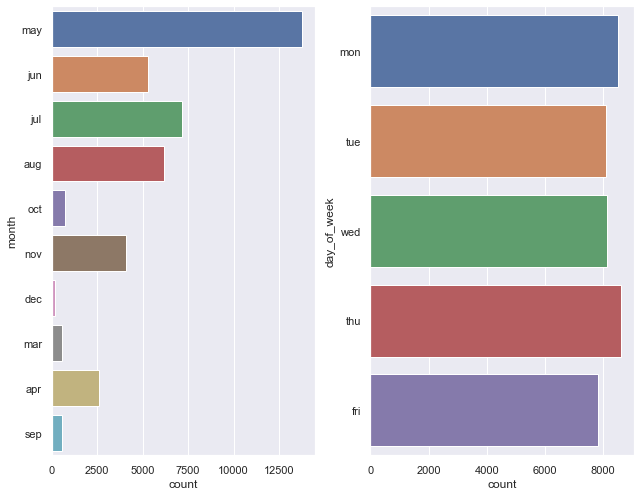

In [16]:
fig, axs = plt.subplots(ncols=2, figsize=(9, 7))

sns.countplot(y="month", data=bank, ax=axs[0])
sns.countplot(y="day_of_week", data=bank, ax=axs[1])
plt.tight_layout()
plt.show()

Conclusões sobre as variáveis categóricas:

* Podemos agregar as categorias em `education` com base se a categoria é de educação primária, secundária ou terciária;
* Em `default` só existem 3 indivíduos para a categoria "yes": vamos criar uma dummy que é 1 se a categoria é "no" e 0 caso contrário;
* Em `month` alguns meses tem poucas observações e outros tem bastante. Vamos testar agregações em trimestres e bimestres para ter categorias mais representativas.

### Análise Bivariada

#### Variáveis Numéricas

In [17]:
bank.groupby("y").mean()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
y,,,,,,,,,,
no,39.911185,220.844807,2.633085,984.113878,0.132374,0.248875,93.603757,-40.593097,3.811491,5176.166600
yes,40.913147,553.191164,2.051724,792.035560,0.492672,-1.233448,93.354386,-39.789784,2.123135,5095.115991


Entre as variáveis numéricas:

* `age` indica que os clientes que fizeram o investimento são em média um ano mais velhos;
* `campaign` indica que os clientes que fizeram o investimento receberam menos ligações em média durante a campanha, ao passo que `pdays` e `previous` indicam que o contato em campanhas anteriores parece ser, na média, um fator importante para a decisão de investimento;
* Entre os indicadores econômicos: decisões por investimento acontecerem, em média, durante períodos em que houve queda na taxa de emprego (`emp.var.rate`), de menores taxas de juros (`euribor3m`), de números menores de emprego (`nr.employed`) e de inflação (`cons.price.idx`) e maior índice de confiança do consumidor (`cons.conf.idx`).

#### Variáveis Categóricas

Vamos tentar plotar duas coisas para cada variável categorica: o numéro de clientes que optaram pelo investimento vs o número de clientes que não optaram pelo investimento, e a porcentagem de clientes em cada categoria que optaram pelo investimento. Para isso, será criada uma função simples para aplicar em cada categoria

In [178]:
def plot_category(df, col):
    df_ = df.copy()
    tab = df_.groupby([col, "y"]).agg(n=("y", lambda x: x.value_counts())).reset_index()
    tab["%"] = tab["n"] / tab.groupby(col)["n"].transform("sum")
    
    fig, axes = plt.subplots(ncols=2, figsize=(9, 7), sharey=True)
    sns.barplot(x="n", y=col, hue="y", data=tab, ax=axes[0])
    sns.barplot(x="%", y=col, data=tab.query("y == 'yes'"), color="#cc8963", ax=axes[1])
    axes[1].set_xlabel("% of 'yes'")
    plt.tight_layout()
    plt.show()

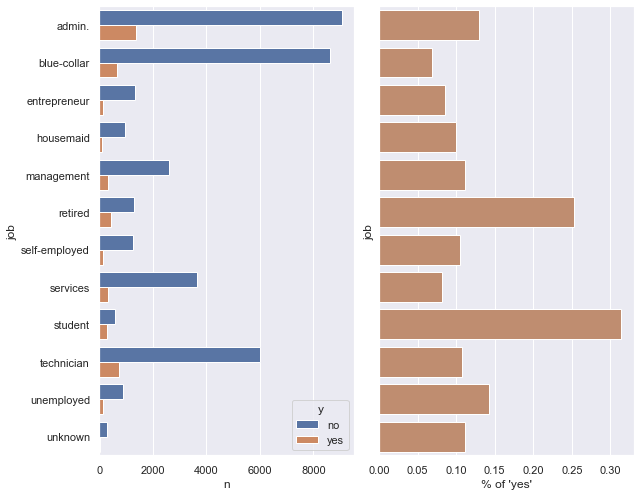

In [179]:
plot_category(bank, "job")

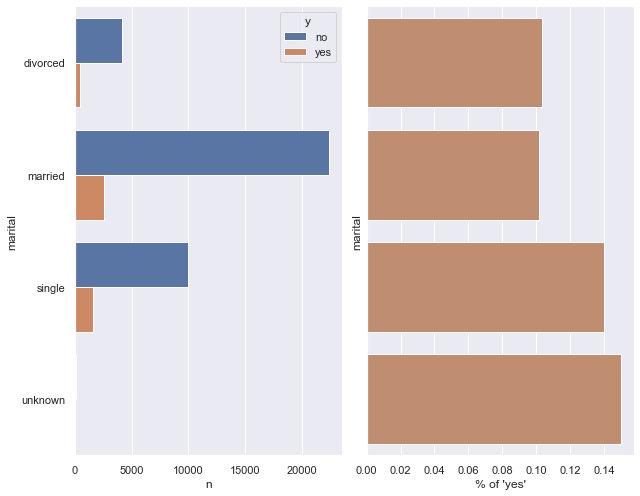

In [180]:
plot_category(bank, "marital")

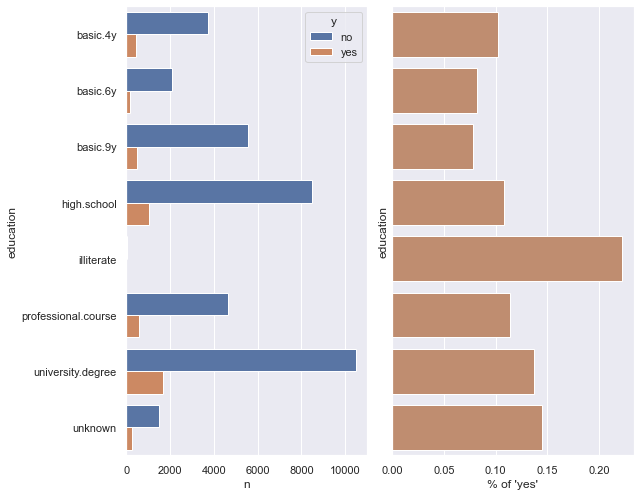

In [181]:
plot_category(bank, "education")

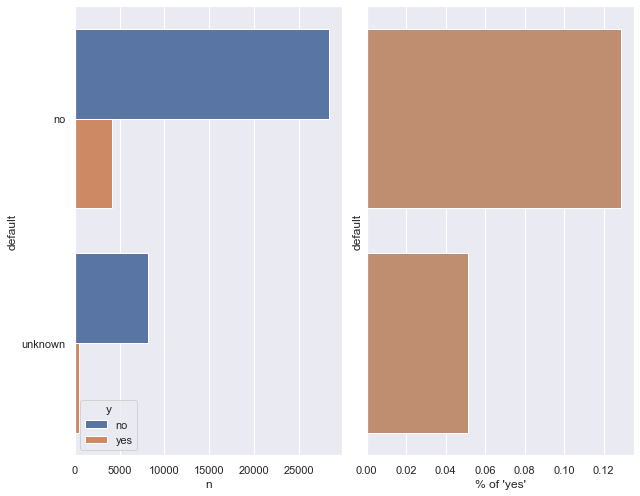

In [182]:
plot_category(bank, "default")

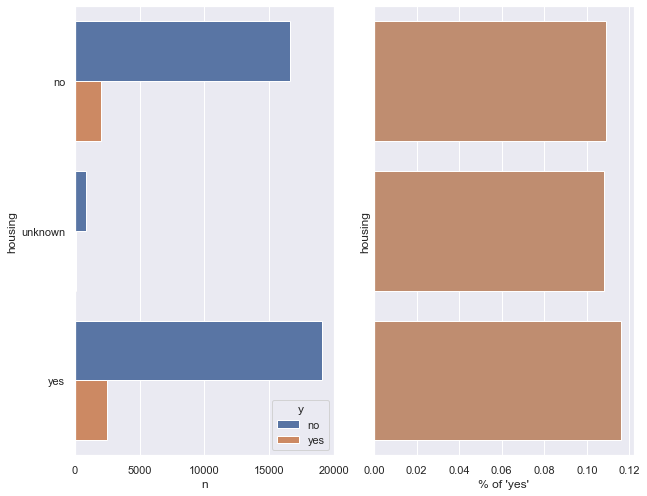

In [183]:
plot_category(bank, "housing")

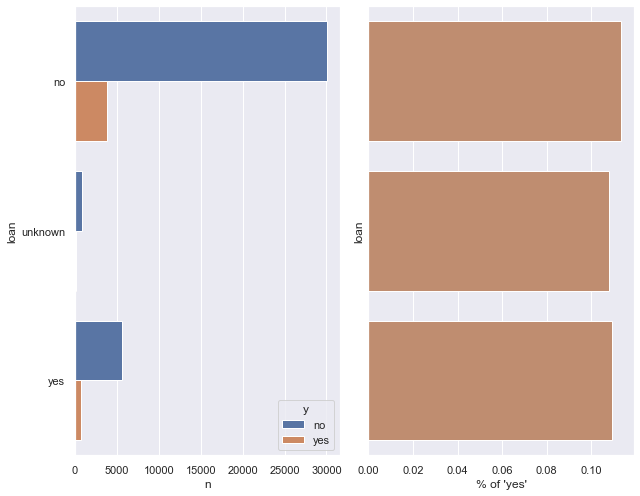

In [184]:
plot_category(bank, "loan")

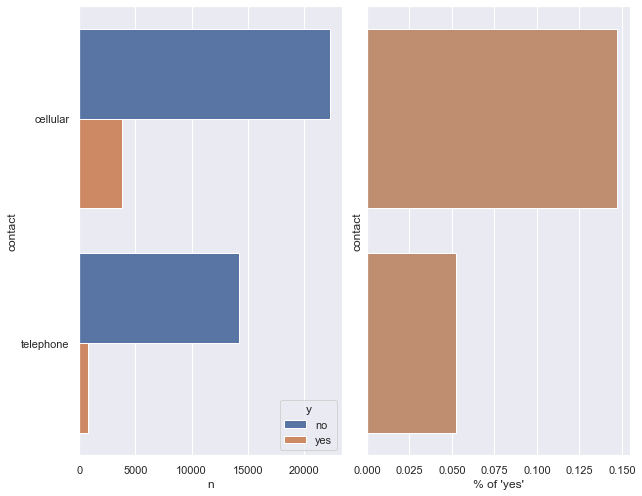

In [185]:
plot_category(bank, "contact")

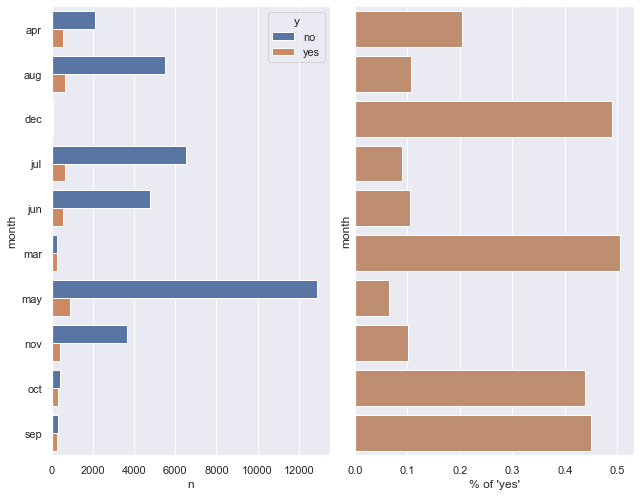

In [186]:
plot_category(bank, "month")

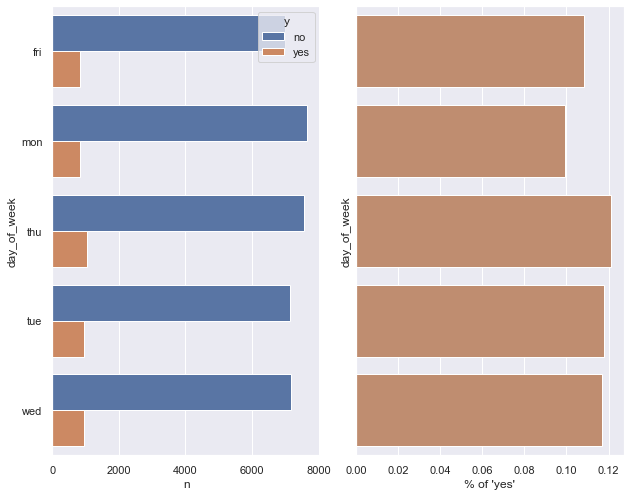

In [187]:
plot_category(bank, "day_of_week")

Alguns destaques:

* Apesar de admin., blue-collar e technician serem a maioria dos clientes em `job`, retired e students são os clientes que proporcionalmente são os que mais optam pelo investimento;
* Em `education`, ilitarates são mais propensos, proporcionalmente, a fazer o investimento. Mas essa categoria é bastante pequena em números absolutos (a ponto de sumir da escala do gráfico), de forma que é dificil concluir que este seja um grupo importante para se focar;
* Em `month` os meses com maior proporção de clientes que optaram pelo investimento também são os meses com menor número de ligações, principalmente em dezembro. Portanto também é difícil que as ligações devem se focar nesses meses.

## Modelando

Precisamos deixar os dados prontos para treinar alguns modelos e para isto vamos preparar uma pipeline no sklearn.

In [105]:
from sklearn.base import BaseEstimator, TransformerMixin
# Transformers

class CombineEducation(BaseEstimator, TransformerMixin):
    def __init__(self, replace_to="basic"):
        self.replace_to = replace_to
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_prep = X.copy()
        X_prep["education"] = X_prep["education"].apply(lambda x: self.replace_to if x in ["basic.4y", "basic.6y", "basic.9y"] else x)
        return X_prep

class ReplacePDays(BaseEstimator, TransformerMixin):
    def __init__(self, replace_to=-1):
        self.replace_to = replace_to
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_prep = X.copy()
        X_prep["pdays"] = X_prep["pdays"].apply(lambda x: self.replace_to if x == 999 else x)
        return X_prep

In [106]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score

In [107]:
bank_train_feats = bank_train.drop("y", axis=1)
bank_train_label = bank_train["y"].copy().apply(lambda x: 1 if x == "yes" else 0)

bank_test_feats = bank_test.drop("y", axis=1)
bank_test_label = bank_test["y"].copy().apply(lambda x: 1 if x == "yes" else 0)

In [108]:
cat_pipe = Pipeline([
    ("comb_education", CombineEducation()),
    ("one_hot", OneHotEncoder())
])

num_pipe = Pipeline([
    ("repl_days", ReplacePDays()),
    ("std_scaler", StandardScaler())
])

preproc = ColumnTransformer([
    ("cat_trans", cat_pipe, make_column_selector(dtype_include="object")),
    ("num_trans", num_pipe, make_column_selector(dtype_exclude="object"))
], remainder="passthrough")

clf = Pipeline([
    ("preprocessing", preproc),
    ("logistic", LogisticRegression())
])

In [109]:
bank_train_fpp = preproc.fit_transform(bank_train_feats)
bank_test_fpp = preproc.fit_transform(bank_test_feats)

In [110]:
log_pred

NameError: name 'log_pred' is not defined

In [111]:
log_clf = LogisticRegression()
log_clf.fit(bank_train_fpp, bank_train_label)

C:\Users\silas\Projetos\bank-marketing\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [113]:
log_clf = LogisticRegression()
log_clf.fit(bank_train_fpp, bank_train_label)
log_pred = log_clf.predict(bank_test_fpp)
roc_auc_score(bank_test_label, log_pred)

C:\Users\silas\Projetos\bank-marketing\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.6765920828120153

In [114]:
rfor_clf = RandomForestClassifier()
rfor_clf.fit(bank_train_fpp, bank_train_label)
rfor_pred = rfor_clf.predict(bank_test_fpp)
roc_auc_score(bank_test_label, rfor_pred)

0.6945874567650355

In [78]:
bank_train

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
12556,40,blue-collar,married,basic.9y,unknown,yes,no,telephone,jul,mon,...,2,999,0,nonexistent,1.4,93.918,-42.7,4.960,5228.1,no
35451,31,admin.,married,university.degree,no,no,no,cellular,may,mon,...,4,999,0,nonexistent,-1.8,92.893,-46.2,1.244,5099.1,no
30592,59,retired,married,basic.4y,no,no,no,cellular,may,mon,...,6,999,1,failure,-1.8,92.893,-46.2,1.354,5099.1,no
17914,43,housemaid,divorced,basic.9y,no,yes,no,cellular,jul,tue,...,5,999,0,nonexistent,1.4,93.918,-42.7,4.961,5228.1,no
3315,39,admin.,single,high.school,unknown,no,no,telephone,may,thu,...,2,999,0,nonexistent,1.1,93.994,-36.4,4.860,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6265,58,retired,married,professional.course,unknown,no,no,telephone,may,tue,...,2,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
11284,37,management,married,university.degree,no,no,no,telephone,jun,thu,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.961,5228.1,no
38158,35,admin.,married,high.school,no,yes,no,cellular,oct,thu,...,1,4,1,success,-3.4,92.431,-26.9,0.754,5017.5,yes
860,40,management,married,university.degree,no,yes,no,telephone,may,wed,...,2,999,0,nonexistent,1.1,93.994,-36.4,4.856,5191.0,no


In [77]:
bank_test

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
32884,57,technician,married,high.school,no,no,yes,cellular,may,mon,...,1,999,1,failure,-1.8,92.893,-46.2,1.299,5099.1,no
3169,55,unknown,married,unknown,unknown,yes,no,telephone,may,thu,...,2,999,0,nonexistent,1.1,93.994,-36.4,4.860,5191.0,no
32206,33,blue-collar,married,basic.9y,no,no,no,cellular,may,fri,...,1,999,1,failure,-1.8,92.893,-46.2,1.313,5099.1,no
9403,36,admin.,married,high.school,no,no,no,telephone,jun,fri,...,4,999,0,nonexistent,1.4,94.465,-41.8,4.967,5228.1,no
14020,27,housemaid,married,high.school,no,yes,no,cellular,jul,fri,...,2,999,0,nonexistent,1.4,93.918,-42.7,4.963,5228.1,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12322,27,services,married,high.school,unknown,no,no,telephone,jul,fri,...,1,999,0,nonexistent,1.4,93.918,-42.7,4.959,5228.1,yes
23440,41,technician,divorced,professional.course,no,no,no,cellular,aug,wed,...,7,999,0,nonexistent,1.4,93.444,-36.1,4.964,5228.1,no
29431,46,entrepreneur,single,university.degree,no,yes,yes,cellular,apr,mon,...,12,999,1,failure,-1.8,93.075,-47.1,1.405,5099.1,no
16627,31,admin.,single,university.degree,no,yes,no,cellular,jul,wed,...,2,999,0,nonexistent,1.4,93.918,-42.7,4.963,5228.1,yes


In [76]:
#bank_train_fpp.shape
bank_test_fpp.shap

(8238, 60)

In [42]:
log_clf = LogisticRegression()

In [43]:
log_clf.fit(bank_train_fpp, bank_train_label)

C:\Users\silas\Projetos\bank-marketing\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [47]:
clf.fit(bank_train_feats, bank_train_label)

C:\Users\silas\Projetos\bank-marketing\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_trans',
                                                  Pipeline(steps=[('comb_education',
                                                                   CombineEducation()),
                                                                  ('one_hot',
                                                                   OneHotEncoder())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001FCE44CAD90>),
                                                 ('num_trans',
                                                  Pipeline(steps=[('repl_days',
                                                                   ReplacePDays()),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001FCE44CAAC0>)])),
                ('logistic', LogisticRegression())])

In [51]:
clf.named_steps["preprocessing"]

ColumnTransformer(remainder='passthrough',
                  transformers=[('cat_trans',
                                 Pipeline(steps=[('comb_education',
                                                  CombineEducation()),
                                                 ('one_hot', OneHotEncoder())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001FCE44CAD90>),
                                ('num_trans',
                                 Pipeline(steps=[('repl_days', ReplacePDays()),
                                                 ('std_scaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001FCE44CAAC0>)])

In [61]:
clf.score(bank_test_feats, bank_test_label)

0.9107793153678078

In [59]:
clf.score(bank_train_feats, bank_train_label)

0.9114112291350531

In [46]:
clf.named_steps["logistic"].coef_

AttributeError: 'LogisticRegression' object has no attribute 'coef_'

In [132]:
bank_train_pp = preproc.fit_transform(bank_train_feats)

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.001669,-0.631114,-0.206242,-0.170614,-0.350902,0.838794,0.589080,-0.472769,0.771354,0.843165
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.864095,-0.546321,0.513676,-0.170614,-0.350902,-1.199440,-1.180760,-1.229916,-1.372028,-0.939748
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.819007,-0.943306,1.233593,-0.170614,1.677559,-1.199440,-1.180760,-1.229916,-1.308581,-0.939748
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.285806,-0.631114,0.873635,-0.170614,-0.350902,0.838794,0.589080,-0.472769,0.771930,0.843165
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.097494,0.332441,-0.206242,-0.170614,-0.350902,0.647709,0.720307,0.890097,0.713674,0.330405
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32945,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.723182,0.652341,-0.206242,-0.170614,-0.350902,0.647709,0.720307,0.890097,0.711943,0.330405
32946,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,-0.289144,0.116604,-0.566200,-0.170614,-0.350902,0.838794,1.533570,-0.278074,0.771930,0.843165
32947,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.480795,-0.245692,-0.566200,3.172077,1.677559,-2.218556,-1.978483,2.945212,-1.654659,-2.067543
32948,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,-0.001669,0.143584,-0.206242,-0.170614,-0.350902,0.647709,0.720307,0.890097,0.711367,0.330405


In [29]:
repl_pdays = ReplacePDays()

In [30]:
repl_pdays.transform(bank_train["pdays"])

12556   -1
35451   -1
30592   -1
17914   -1
3315    -1
        ..
6265    -1
11284   -1
38158    4
860     -1
15795   -1
Name: pdays, Length: 32950, dtype: int64

In [23]:
comb_educ = CombineEducation()

In [26]:
comb_educ.transform(bank_train["education"])

12556                  basic
35451      university.degree
30592                  basic
17914                  basic
3315             high.school
                ...         
6265     professional.course
11284      university.degree
38158            high.school
860        university.degree
15795      university.degree
Name: education, Length: 32950, dtype: object

In [119]:
numeric_pipeline = Pipeline([
    ("repl_pdays", ReplacePDays())
])

cat_pipeline = Pipeline([
    ("comb_educ", CombineEducation())
])

In [120]:
teste = numeric_pipeline.fit_transform(bank_train)

In [123]:
teste[:, 12]

array([-1, -1, -1, ..., 4, -1, -1], dtype=object)

In [105]:
num_cols = ["age", "duration", "campaign", "pdays", "previous", "emp.var.rate", "cons.price.idx", "cons.conf.idx", "euribor3m", "nr.employed"]